[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
Nani?! in data
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.23738952 0.93958657]
 [0.15941873 0.00679135 0.2424201  0.91673288]
 ...
 [0.75404546 0.86439547 0.17675049 0.75198726]
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.05123506, 0.0489875 , 0.0511671 , ..., 0.05268165, 0.05230058,
        0.05699958],
       [0.0489875 , 0.0511671 , 0.04487103, ..., 0.05230058, 0.05699958,
        0.05885636],
       [0.0511671 , 0.04487103, 0.0414924 , ..., 0.05699958, 0.05885636,
        0.05701414],
       ...,
       [0.721053  , 0.73846792, 0.71939765, ..., 0.76355265, 0.76899683,
        0.76521772],
       [0.73846792, 0.71939765, 0.70608468, ..., 0.76899683, 0.76521772,
        0.75404546],
       [0.71939765, 0.70608468, 0.72861117, ..., 0.76521772, 0.75404546,
        0.77007934]])

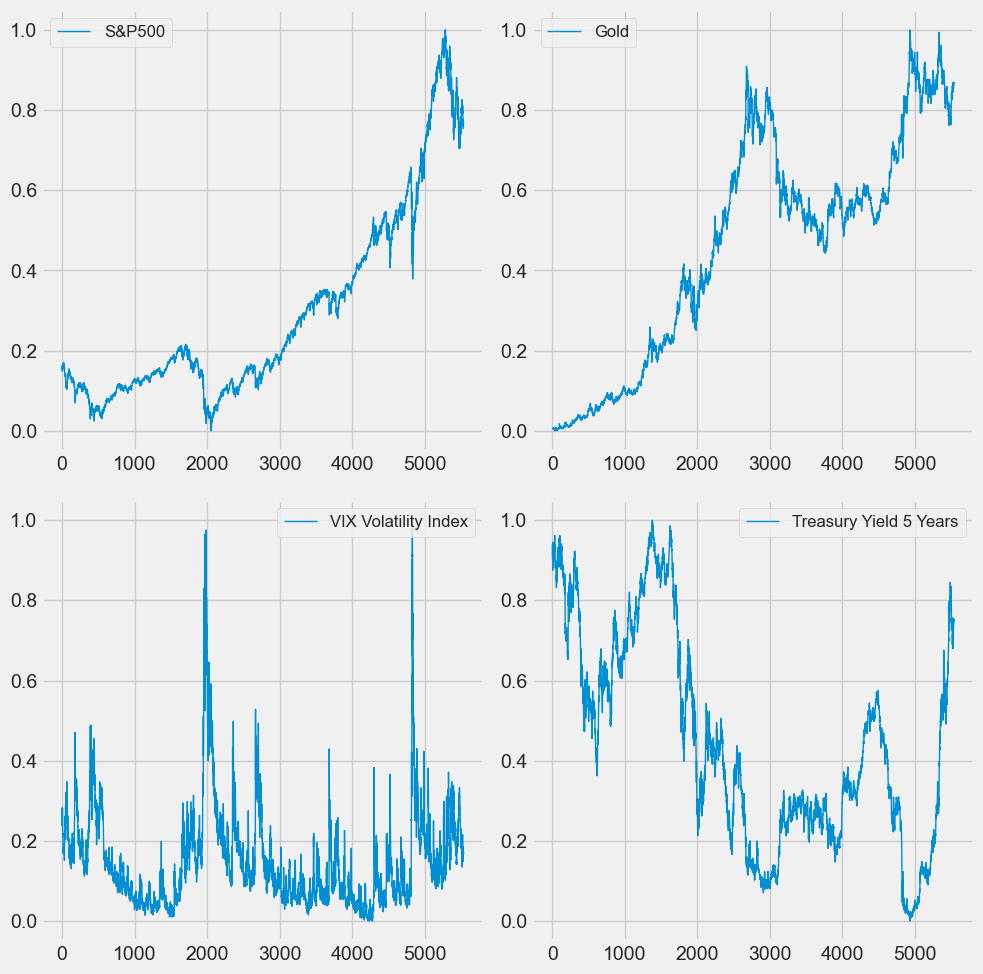

In [7]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass as dataclass
reload(dataclass)

input_length = 512
output_length = 64
database = dataclass.StockData(input_length,output_length)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [8]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Stockdataset(Dataset):
    def __init__(self, data, input_length = 128, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
        
size_training = int(len(database.data_norm)*0.85)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = Stockdataset(data_train, input_length, output_length)
test_dataset = Stockdataset(data_test, input_length, output_length)
whole_dataset = Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[1].shape)
print(whole_dataset.__getitem__(0)[0].shape)


(4708, 4)
(831, 4)
torch.Size([512, 4])
torch.Size([64])
torch.Size([512, 4])


In [9]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True)
whole_dataloader = DataLoader(whole_dataset, 1, drop_last = False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [10]:
class EvolvingSystem(nn.Module):
    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters):
        super(EvolvingSystem, self).__init__()
        self.input_size = input_dim
        self.output_size = output_dim
        self.cluster_dim = cluster_dim
        self.num_clusters = num_clusters
        self.mu = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.sigma_inv = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim, self.cluster_dim), requires_grad=True)
        self.fc_ant = nn.Linear(input_length, self.cluster_dim) #self.cluster_dim
        self.fc_con = nn.Linear(input_length, output_length) #output_length
        self.sm = torch.nn.Softmax(dim = 1)
        self.layer_norm = nn.LayerNorm(input_length)
        
    def forward(self, x):
        #torch.Size([256, 128, 16]); IxBxH
        #self.x = x.flatten()
        x = x.reshape(batch_size,1,input_length)
        x_con = x.reshape(batch_size,1,input_length)
        
        x = self.layer_norm(x)
        self.x_ant = self.fc_ant(x)
        self.x_ant = self.x_ant
        d = torch.sub(self.mu, self.x_ant)
        dl = d.reshape(batch_size,self.num_clusters,1,self.cluster_dim)
        #TEST OK -> self.mu-self.x_ant[0][0], d[0], dl[0]
        
        #sigma_inv = self.sigma_inv + torch.transpose(self.sigma_inv, 2, 1)
        sigma_inv = torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1))
        
        d2_dS = torch.matmul(dl, sigma_inv)
        dr = d.reshape(batch_size,self.num_clusters,self.cluster_dim,1)
        d2 = torch.matmul(d2_dS, dr)
        psi = self.sm(-d2).reshape(batch_size,1,self.num_clusters)
        #TEST OK -> self.sm(-d2).reshape(batch_size,1,self.num_clusters)[0], self.sm(-d2)
        
        x_con = x_con.repeat(1,self.num_clusters,1)
        y_con = self.fc_con(x_con)#.reshape(batch_size, -1, self.num_clusters) #.reshape(batch_size, output_length, self.num_clusters)
        y =  torch.matmul(psi,y_con)
        
        #final_out = self.fc(out)
        return y

In [11]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.evolve = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters)
        #self.fc = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,hidden_size)

    def forward(self, x, hn, cn):
        out, (hn, cn) = self.lstm(x, (hn,cn))
        #torch.Size([256, 128, 16]); IxBxH
        out = self.fc(out)
        final_out = self.evolve(out)
        #final_out = self.fc(out)
        return final_out, hn, cn

    def predict(self, x):
        hn, cn = self.init()
        out = self.fc(out)
        final_out = self.evolve(out)
        #final_out = self.fc(out)
        return final_out, hn, cn 

    def init(self):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je batch_size tako?
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h0,c0


cluster_dim = 2
num_clusters = 128
input_dim = 4
output_dim = 1
hidden_size = input_length//16
num_layers = 2
model = Lstm_model(input_dim, output_dim, hidden_size, num_layers).to(device)



In [12]:
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [13]:
def train(dataloader):
    hn, cn = model.init()
    model.train()
    loss_sum = 0
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        #out, hn, cn = model(x, hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        hn = hn.detach() #detach hn is not a parameters and does not need to be updated!!!
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Train loss: {loss_sum:>7f}")
    return loss_sum

In [14]:
def test(dataloader):
    hn, cn = model.init()
    loss_sum = 0
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Test loss: {loss_sum:>7f}")   
    return loss_sum
            

In [15]:
epochs = 1000
best_model = 1
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    loss_train = train(train_dataloader)
    loss_test = test(test_dataloader)
    if (best_model > loss_train):
        best_model = loss_train
        #state = {
        #'epoch': epoch,
        #'state_dict': model.state_dict(),
        #'optimizer': optimizer.state_dict()}
        torch.save(model.state_dict(), "model_multivariate")
    
#torch.save(model.state_dict(), "model_multivariate")

Epoch 0
Train loss: 1.424809
Test loss: 0.626009
Epoch 1
Train loss: 0.644611
Test loss: 0.487469
Epoch 2
Train loss: 0.713479
Test loss: 0.474039
Epoch 3
Train loss: 0.676230
Test loss: 0.464964
Epoch 4
Train loss: 0.650179
Test loss: 0.453652
Epoch 5
Train loss: 0.628062
Test loss: 0.441873
Epoch 6
Train loss: 0.603234
Test loss: 0.428585
Epoch 7
Train loss: 0.575265
Test loss: 0.413077
Epoch 8
Train loss: 0.543043
Test loss: 0.394629
Epoch 9
Train loss: 0.505697
Test loss: 0.372536
Epoch 10
Train loss: 0.463650
Test loss: 0.346505
Epoch 11
Train loss: 0.420247
Test loss: 0.317461
Epoch 12
Train loss: 0.383186
Test loss: 0.288597
Epoch 13
Train loss: 0.360569
Test loss: 0.264788
Epoch 14
Train loss: 0.349663
Test loss: 0.248509
Epoch 15


KeyboardInterrupt: 

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x, hn, cn)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0].reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        return math.sqrt(mean_squared_error(y_arr,pred_arr))



In [ ]:

model.load_state_dict(torch.load("model_multivariate"))
model.eval()


Lstm_model(
  (lstm): LSTM(4, 32, num_layers=2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (evolve): EvolvingSystem(
    (fc_ant): Linear(in_features=512, out_features=2, bias=True)
    (fc_con): Linear(in_features=512, out_features=64, bias=True)
    (sm): Softmax(dim=1)
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
)

In [ ]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

In [17]:
def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred = model(x.reshape(input_length, batch_size, input_dim), hn, cn)[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = pred_arr + list(pred[-1])
            y_arr = y_arr + list(y[-1])
        return pred_arr, y_arr


In [18]:
batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)

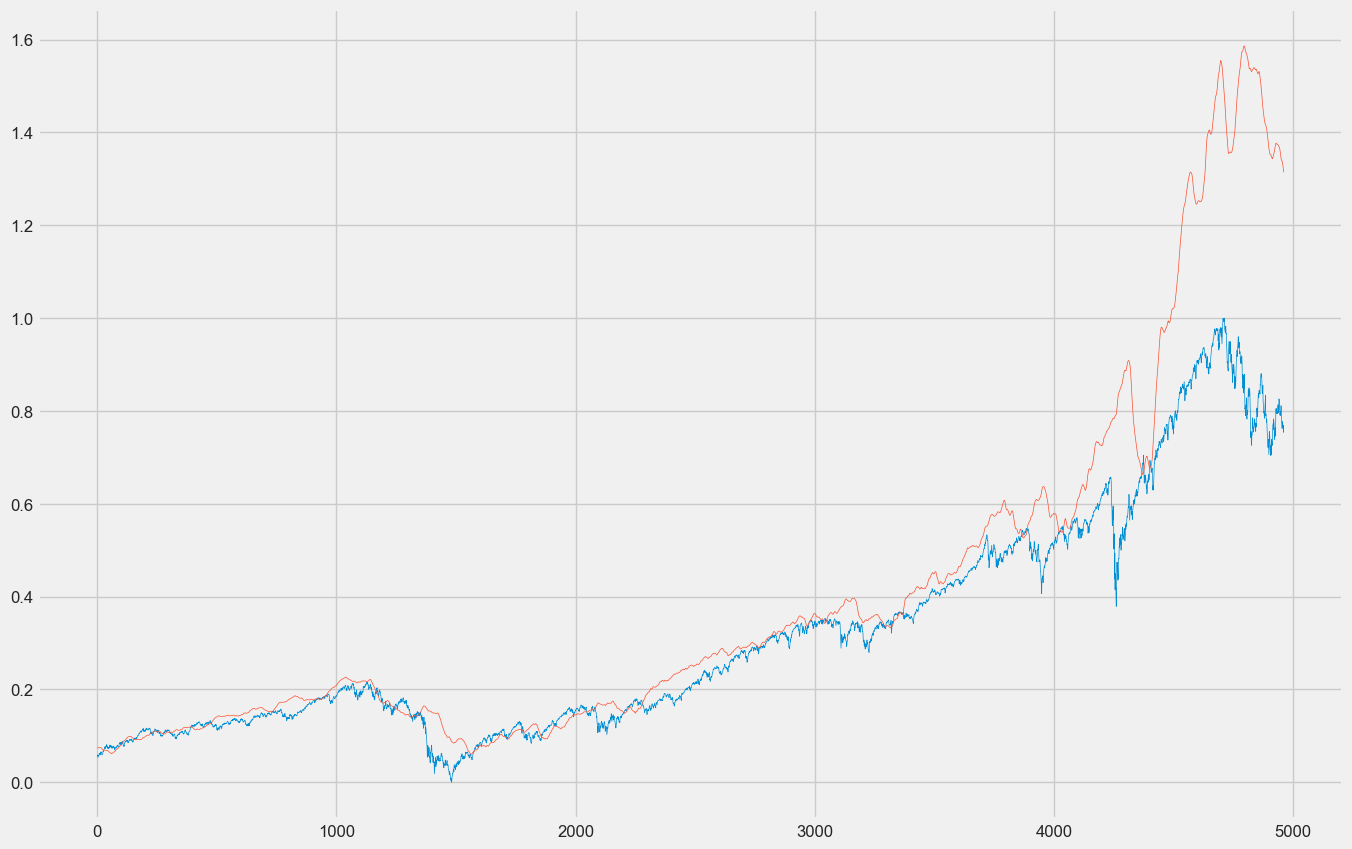

In [ ]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(figsize = (15, 10))
axes1.plot(whole_y_arr, linewidth=0.5)
axes1.plot(whole_pred_arr, linewidth=0.5)
fig1.savefig("whole_miltivariate.pdf")

torch.Size([128, 3, 3])
torch.Size([128, 3])


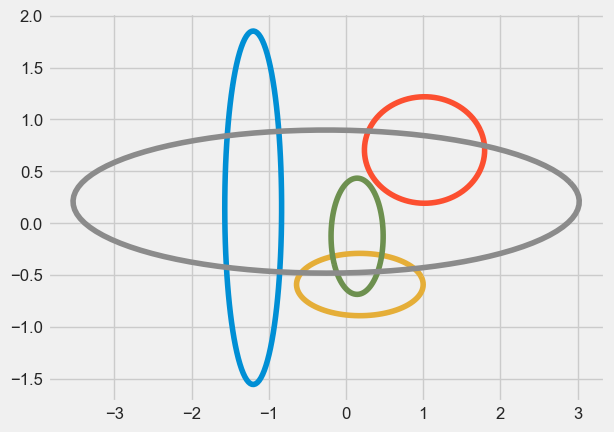

In [ ]:
from importlib import reload 
import compute_ellipse
from numpy.linalg import inv
reload(compute_ellipse)

print(model.evolve.sigma_inv.shape)
print(model.evolve.mu.shape)


sigma_inv = model.evolve.sigma_inv
sigma_inv = sigma_inv + torch.transpose(sigma_inv, 2, 1)
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())

sigma = sigma[0:5,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()
mu = mu[0:5,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)

plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()

In [ ]:
history -g


 1/1:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0', new_step_api=True, render_mode='single_rgb_array').unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 1/2:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0', new_step_api=True, render_